In [17]:
import os
from astropy.table import Table
import pickle
import pandas as pd
import illustris_python as il

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
# file_dir='/hildafs/home/amshakir/corr_pc/corr_pc/temp/ill_test/' #directory where files for corr_pc will be placed. I recommend using full path rather than relative path as here.
cat = 'rsd_r_mu'
file_dir='/hildafs/home/amshakir/corr_pc/corr_pc/temp/ia_project/density_auto/'+cat+'/'
file_name='data_'+cat  #prefix to be appended to the files being saved. Should be different for different datasets.

os.makedirs(file_dir,exist_ok=True)

In [19]:
""" this function generates the input file for corr_pc
 corr_pc takes two samples to compute cross correlations. 
 Shape sample: Sample of galaxies with shapes. For density correlations it is not necessary to pass shapes. 
               Prefix of filenames for this sample should be passed vias file_nameS
 Density sample: Sample of galaxies/particles that trace density field. For density correlations it is not necessary to pass shapes. 
                 If shapes are passed for this sample, w++ can be computed. Prefix of filenames for this sample should be passed vias file_nameD.
                 If auto correlation is to be computed, simply set file_nameD=file_nameS.
 file_name: This is the prefix corr_pc will use to save the output files containing two point correlations. Input file to be passed to corr_pc is 
            also saved with this name. input file is saved in file_dir and the outputs are saved in new directory, file_dir+corr_data_out.
 corr: two point correlation to be computed. This should be density-density (wgg,wmm), shape-density (wg+) or shape-shape(w++). 
        When computing wg+, corr_pc will also compute and save wgg by default since pair counting is done anyways. 
        When doing w++, wg+ and wgg are also computed and saved.
 n_shape, n_density: number of galaxies in the shape sample and density sample respectively.
 do_jk: Whether to do jackknifing or not.
 njk: number of jackknife regions. jackknife regions are assumed to be labelled from 0...njk-1.
"""
def inp_gen(file_dir,file_name,file_nameS,file_nameD,corr=1,n_shape=0,n_density=0,njk=100,do_jk=1):
    s=""
    s=s+"which_corr     "+str(corr)+"\n" #0: density-density, 1: ia: shape-density, 2 ia:shape-shape,
    s=s+"coordinates    7"+"\n"  #6: rp-pi , 7:r-mu
    s=s+"estimator      0"+"\n"  #0:landy-szalay (LS): cross. works for both auto and cross correlations. For auto, pass same filenames for shape and density samples 
                                 # 1: LS:auto, for auto correlation only
    s=s+"data_sorted     0"+"\n"  #0: no sorting, 1:sorted by z, 2:sorted by dec (y)
    s=s+"use_comoving    1"+"\n"
    s=s+"do_jk           "+str(do_jk)+"\n" #0: no jackknife, 1: do jackknife. jk regions must be passed in a file. are assumed to be from 0..njk-1
    s=s+"sig_crit        0"+"\n" #for weak lensing, not important for ia, gg corrs.

    #following passes information about shape sample
    s=s+"shape_pos       "+file_dir+file_nameS+'_pos.dat'+"\n"  # x, y coordinates
    s=s+"shape_z         "+file_dir+file_nameS+'_z.dat'+"\n"    # z coordinate
    s=s+"shape_e         "+file_dir+file_nameS+'_e.dat'+"\n"    # e1, e2
#     s=s+"shape_wt         "+file_dir+file_nameS+'_wt.dat'+"\n"  # weights on galaxies. If no weighting, pass 0
    s=s+"shape_wt         0"+"\n"
    s=s+"shape_jk        "+file_dir+file_nameS+'_jk.dat'+"\n"   # jackknife regions

    # following passes information about density sample
    s=s+"density_patch   0"+"\n" #for weak lensing, not important for ia, gg corrs.
    s=s+"density_pos     "+file_dir+file_nameD+'_pos.dat'+"\n"  # x, y coordinates
    s=s+"density_z       "+file_dir+file_nameD+'_z.dat'+"\n"    # z coordinate
    s=s+"density_wt       0"+"\n"  # weights on galaxies/particles. If no weighting, pass 0
#     s=s+"density_wt       "+file_dir+file_nameD+'_wt.dat'+"\n"  # weights on galaxies/particles. If no weighting, pass 0
    s=s+"density_jk      "+file_dir+file_nameD+'_jk.dat'+"\n"   # jackknife regions    
    s=s+"density_e      0"+"\n"   #if doing shape-shape, this file should be passed. # e1, e2

    # following passes information about randoms corresponding to shape sample
    s=s+"Srandom_pos      0"+"\n"
    s=s+"Srandom_z        0"+"\n"
    s=s+"Srandoms_wt      0"+"\n"
    s=s+"Srand_jk         0"+"\n"

    # following passes information about randoms corresponding to density sample
    s=s+"Drandom_patch    0"+"\n"
    s=s+"Drandom_pos      0"+"\n"
    s=s+"Drandom_z        0"+"\n"
    s=s+"Drandoms_wt      0"+"\n"
    s=s+"drand_jk         0"+"\n"

    s=s+"distances        0"+"\n"  #not needed for PB
    s=s+"patch_file       0"+"\n"  #not needed for PB
    s=s+"out_file         "+file_dir+"corr_data_out/"+file_name+"_"+"\n"  # prefix for the output files.
    
    os.makedirs(file_dir+"corr_data_out/",exist_ok=True) #directory where outputs are saved.
    
    s=s+"n_threads       0"+"\n"   # number of openmp threads to use. 0== use maximum available.
    s=s+"n_shape         "+str(n_shape)+"\n"  #number of galaxies in shape sample
    s=s+"n_density       "+str(n_density)+"\n"  #number of galaxies in density sample
    s=s+"n_Srand         0"+"\n"
    s=s+"n_Drand         0"+"\n"
    s=s+"rand_subsample  0"+"\n"  #subsample randoms to speed up calculations.
    s=s+"n_jk          "+str(njk)+"\n"  #number of jk regions. regions are assumed to be labelled from 0....njk-1
    s=s+"n_patch         0 "+"\n"#not needed for PB

    s=s+"binR_min        2"+"\n"  # rp_min for the bins
    s=s+"binR_max       25"+"\n" # rp_max for the bins #originally 20
    s=s+"n_bins         10"+"\n" #number of rp bins to use #originally 10
    s=s+"lin_bin         0"+"\n"  #linear or log bins. 0: log, 1:linear
    s=s+"n_p_bin         20"+"\n"  #number of pi bins to use # 20 for mu
    s=s+"pmin         -1"+"\n"  # pi_min (line of sight or z separation) -1 for mu
    s=s+"pmax         1"+"\n"   # pi_max (line of sight or z separation) 1 for mu
    s=s+"z_min         0"+"\n"    
    s=s+"z_max         300"+"\n" 
    s=s+"dz            0.0001"+"\n" #not needed for PB
    s=s+"z_sep_min     -100"+"\n"  
    s=s+"z_sep_max     100"+"\n"   
    s=s+"periodic_box  1"+"\n"
    s=s+"box_size     75"+"\n"  #size of the box.

    fil=open(file_dir+file_name+'.inp','w')
    fil.write(s)


In [20]:
og_cat_path = '/hildafs/datasets/IllustrisTNG/TNG100-1/output'
snapNum=99

fields = ['SubhaloVel']
subhalos=il.groupcat.loadSubhalos(og_cat_path,snapNum,fields=fields)

len(subhalos)

4371211

In [21]:
H_0 = 67.4 # (km/s)/(Mpc)
h = H_0 / 100 # little h

print(100*h)

67.4


In [22]:
"""
This function splits the sim box into a grid in x-y plane. Number of grid splits along each axis are given by njk1, for a total of njk1^2 sub-sample regions.
After this, each point in data (galaxy or particle) is assigned to its sub-sample.
"""
def jk_box(data=[],Lbox=None,njk1=7):
    if Lbox is None:
        Lbox=np.ceil(max(data['gal_pos_x']))
        print('jk_box using Lbox=',Lbox)
    xjk=np.linspace(0,Lbox,njk1+1)
    yjk=np.linspace(0,Lbox,njk1+1)
    jk=np.zeros(len(data))
    jjk=0
    for i in np.arange(njk1):
        xil=xjk[i]
        xih=xjk[i+1]
        x1=data['gal_pos_x']>xil
        x2=data['gal_pos_x']<xih
        for j in np.arange(njk1):
            yil=yjk[j]
            yih=yjk[j+1]
            y1=data['gal_pos_y']>yil
            y2=data['gal_pos_y']<=yih
            jk[x1*x2*y1*y2]=jjk
            jjk+=1
#     jk=np.array(jk,dtype=[('jk','int32')])
    return jk


In [23]:
fname='/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_component_shapes_3I_subfind_FULL_mass-cut9.p'

def wrap_pos(pos):
    if pos > 75:
        return pos - 75
    elif pos < 0:
        return pos + 75
    else:
        return pos

with open(fname, "rb") as input_file:    
    S_df = pd.DataFrame(pickle.load(input_file)).groupby(level=0, axis=1).last()
    print(len(S_df['gal_id']))
    S_df['vel_z'] = subhalos[S_df['gal_id'].astype('int')][:,2]
    
    S_df['gal_pos_z_rsd'] = S_df['gal_pos_z'] + (S_df['vel_z'] /  100)
    S_df['gal_pos_z_rsd'] = S_df['gal_pos_z_rsd'].apply(wrap_pos)
    print(len(S_df['gal_id']))
    
    S_dat = Table.from_pandas(S_df)
    
    S_dat=S_dat[S_dat['mass'] >= 10**10]
    shape_cutoff = np.percentile(S_dat['mc_disk'], 33.33)
    S_dat = S_dat[S_dat['mc_disk'] <= shape_cutoff]
    
S_dat['jk'] = jk_box(data=S_dat)

#S_dat

20051
20051
jk_box using Lbox= 75.0


In [24]:
D_dat=Table.from_pandas(S_df)

D_dat['jk'] = jk_box(data=D_dat)

# D_dat[['gal_pos_x', 'gal_pos_y', 'gal_pos_z', 'gal_pos_z_rsd', 'vel_z']]

jk_box using Lbox= 75.0


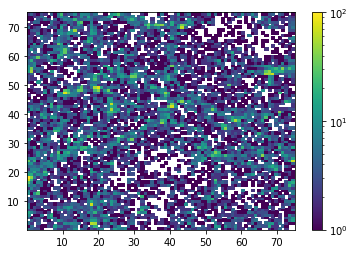

In [25]:
_=hist2d(D_dat['gal_pos_x'],D_dat['gal_pos_z'], 80, norm=matplotlib.colors.LogNorm())
colorbar()

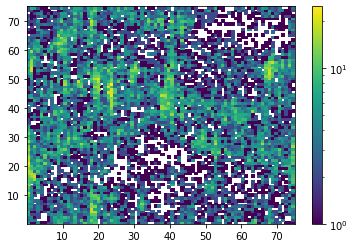

In [26]:
_=hist2d(D_dat['gal_pos_x'],D_dat['gal_pos_z_rsd'], 80, norm=matplotlib.colors.LogNorm())
colorbar()

In [27]:
np.all(S_dat['gal_pos_z'][1:]-S_dat['gal_pos_z'][:-1]>0)

False

In [28]:
"""
Function to write data files in format that can be read by corr_pc
"""
def write_data(data,file_name,file_dir,wt_col=None):
    file_name=file_dir+file_name
    np.savetxt(file_name+'_pos.dat',np.column_stack((data['gal_pos_x'],data['gal_pos_y']))) #x,y position of galaxies
    #np.savetxt(file_name+'_z.dat',data['gal_pos_z']) # z position of galaxies (change to RSD z pos)
    np.savetxt(file_name+'_z.dat',data['gal_pos_z_rsd'])
    if 'jk' in data.columns:
        np.savetxt(file_name+'_jk.dat',data['jk'],fmt='%i') #jackknife is read as integer
    if 'e1' in data.columns: #ellipticities. corr_pc takes e1, e2
        np.savetxt(file_name+'_e.dat',np.column_stack((data['e1'],data['e2']*-1)))
    if wt_col is not None: #wt to be applied to each galaxy/particle.
        wt=data[wt_col]*1.
        wt/=wt.mean()
        np.savetxt(file_name+'_wt.dat',wt)

In [29]:
# FOR AUTOCORR ONLY

S_dat = D_dat

S_dat

a,a_iter_bulge,a_iter_disk,a_reduced_bulge,a_reduced_disk,a_simple_bulge,a_simple_disk,av_iter_bulge_x,av_iter_bulge_y,av_iter_bulge_z,av_iter_disk_x,av_iter_disk_y,av_iter_disk_z,av_reduced_bulge_x,av_reduced_bulge_y,av_reduced_bulge_z,av_reduced_disk_x,av_reduced_disk_y,av_reduced_disk_z,av_simple_bulge_x,av_simple_bulge_y,av_simple_bulge_z,av_simple_disk_x,av_simple_disk_y,av_simple_disk_z,av_x,av_y,av_z,b,b_iter_bulge,b_iter_disk,b_reduced_bulge,b_reduced_disk,b_simple_bulge,b_simple_disk,bv_iter_bulge_x,bv_iter_bulge_y,bv_iter_bulge_z,bv_iter_disk_x,bv_iter_disk_y,bv_iter_disk_z,bv_reduced_bulge_x,bv_reduced_bulge_y,bv_reduced_bulge_z,bv_reduced_disk_x,bv_reduced_disk_y,bv_reduced_disk_z,bv_simple_bulge_x,bv_simple_bulge_y,bv_simple_bulge_z,bv_simple_disk_x,bv_simple_disk_y,bv_simple_disk_z,bv_x,bv_y,bv_z,c,c_iter_bulge,c_iter_disk,c_reduced_bulge,c_reduced_disk,c_simple_bulge,c_simple_disk,central_bool,chisq_exp1,chisq_exp2,cv_iter_bulge_x,cv_iter_bulge_y,cv_iter_bulge_z,cv_iter_disk_x,cv_iter_disk_y,cv_iter_disk_z,cv_reduced_bulge_x,cv_reduced_bulge_y,cv_reduced_bulge_z,cv_reduced_disk_x,cv_reduced_disk_y,cv_reduced_disk_z,cv_simple_bulge_x,cv_simple_bulge_y,cv_simple_bulge_z,cv_simple_disk_x,cv_simple_disk_y,cv_simple_disk_z,cv_x,cv_y,cv_z,e1,e1_iter_bulge,e1_iter_disk,e1_simple_bulge,e1_simple_disk,e2,e2_iter_bulge,e2_iter_disk,e2_simple_bulge,e2_simple_disk,f_disk,gal_id,gal_pos_x,gal_pos_y,gal_pos_z,int_disk_counter_exp1,int_disk_counter_exp2,int_disk_exp1,int_disk_thick,int_disk_thin,mass,mc_disk,vel_z,gal_pos_z_rsd,jk
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
0.2456392176754265,0.002176249399247131,0.0019017093393568477,0.001820713842566015,0.0016030623407716734,0.2543650099428934,0.26301513093904433,-0.31682992740961285,0.3622273061968354,-0.8765900842143971,0.2225071888793727,-0.3865950383248337,0.8950054900611609,0.3048965872583357,-0.3652883808285362,0.8795467411740473,0.2172944483017553,-0.39591502791566935,0.8922076066744618,0.1679423285793415,-0.3717846639776698,0.9130013898687995,0.079028656939103,-0.37520940155154464,0.9235650363508425,0.15055934741250313,-0.36430512412033045,0.9190286499595058,0.11234460931735893,0.0012854166456961473,0.0011786076308427896,0.0013625189927256509,0.0012314713594791535,0.1229083029982789,0.11460319179831346,0.565712217295231,-0.669650962606594,-0.4811832036584148,-0.6123062368732034,0.6589629786959393,0.43686252413585536,-0.5355015529388223,0.6979513374924897,0.47550185834816106,-0.5894375111448259,0.6753520016204922,0.4432415756250628,-0.6165591590108104,0.6830375748400482,0.3915539232296216,-0.5108365408449516,0.7803325794476624,0.3607313321436354,-0.6041285663706352,0.7019474620075364,0.37722464908345976,0.09436756832150874,0.0010592230370142053,0.0008833124507470288,0.0011944163579630596,0.0010028893337798333,0.09788060717286094,0.10606058598399988,1.0,54.325447392257146,69.55300597886202,-0.761307089353917,-0.6483509596857606,0.007249053318934407,0.7586643679409066,0.6452224957724232,0.0900905531453193,0.7875761283065468,0.6159775396263336,-0.017190485669662085,0.7780401938156081,0.6222145647425251,0.08661692807783543,0.76918799893

In [30]:
D_dat

a,a_iter_bulge,a_iter_disk,a_reduced_bulge,a_reduced_disk,a_simple_bulge,a_simple_disk,av_iter_bulge_x,av_iter_bulge_y,av_iter_bulge_z,av_iter_disk_x,av_iter_disk_y,av_iter_disk_z,av_reduced_bulge_x,av_reduced_bulge_y,av_reduced_bulge_z,av_reduced_disk_x,av_reduced_disk_y,av_reduced_disk_z,av_simple_bulge_x,av_simple_bulge_y,av_simple_bulge_z,av_simple_disk_x,av_simple_disk_y,av_simple_disk_z,av_x,av_y,av_z,b,b_iter_bulge,b_iter_disk,b_reduced_bulge,b_reduced_disk,b_simple_bulge,b_simple_disk,bv_iter_bulge_x,bv_iter_bulge_y,bv_iter_bulge_z,bv_iter_disk_x,bv_iter_disk_y,bv_iter_disk_z,bv_reduced_bulge_x,bv_reduced_bulge_y,bv_reduced_bulge_z,bv_reduced_disk_x,bv_reduced_disk_y,bv_reduced_disk_z,bv_simple_bulge_x,bv_simple_bulge_y,bv_simple_bulge_z,bv_simple_disk_x,bv_simple_disk_y,bv_simple_disk_z,bv_x,bv_y,bv_z,c,c_iter_bulge,c_iter_disk,c_reduced_bulge,c_reduced_disk,c_simple_bulge,c_simple_disk,central_bool,chisq_exp1,chisq_exp2,cv_iter_bulge_x,cv_iter_bulge_y,cv_iter_bulge_z,cv_iter_disk_x,cv_iter_disk_y,cv_iter_disk_z,cv_reduced_bulge_x,cv_reduced_bulge_y,cv_reduced_bulge_z,cv_reduced_disk_x,cv_reduced_disk_y,cv_reduced_disk_z,cv_simple_bulge_x,cv_simple_bulge_y,cv_simple_bulge_z,cv_simple_disk_x,cv_simple_disk_y,cv_simple_disk_z,cv_x,cv_y,cv_z,e1,e1_iter_bulge,e1_iter_disk,e1_simple_bulge,e1_simple_disk,e2,e2_iter_bulge,e2_iter_disk,e2_simple_bulge,e2_simple_disk,f_disk,gal_id,gal_pos_x,gal_pos_y,gal_pos_z,int_disk_counter_exp1,int_disk_counter_exp2,int_disk_exp1,int_disk_thick,int_disk_thin,mass,mc_disk,vel_z,gal_pos_z_rsd,jk
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64
0.2456392176754265,0.002176249399247131,0.0019017093393568477,0.001820713842566015,0.0016030623407716734,0.2543650099428934,0.26301513093904433,-0.31682992740961285,0.3622273061968354,-0.8765900842143971,0.2225071888793727,-0.3865950383248337,0.8950054900611609,0.3048965872583357,-0.3652883808285362,0.8795467411740473,0.2172944483017553,-0.39591502791566935,0.8922076066744618,0.1679423285793415,-0.3717846639776698,0.9130013898687995,0.079028656939103,-0.37520940155154464,0.9235650363508425,0.15055934741250313,-0.36430512412033045,0.9190286499595058,0.11234460931735893,0.0012854166456961473,0.0011786076308427896,0.0013625189927256509,0.0012314713594791535,0.1229083029982789,0.11460319179831346,0.565712217295231,-0.669650962606594,-0.4811832036584148,-0.6123062368732034,0.6589629786959393,0.43686252413585536,-0.5355015529388223,0.6979513374924897,0.47550185834816106,-0.5894375111448259,0.6753520016204922,0.4432415756250628,-0.6165591590108104,0.6830375748400482,0.3915539232296216,-0.5108365408449516,0.7803325794476624,0.3607313321436354,-0.6041285663706352,0.7019474620075364,0.37722464908345976,0.09436756832150874,0.0010592230370142053,0.0008833124507470288,0.0011944163579630596,0.0010028893337798333,0.09788060717286094,0.10606058598399988,1.0,54.325447392257146,69.55300597886202,-0.761307089353917,-0.6483509596857606,0.007249053318934407,0.7586643679409066,0.6452224957724232,0.0900905531453193,0.7875761283065468,0.6159775396263336,-0.017190485669662085,0.7780401938156081,0.6222145647425251,0.08661692807783543,0.76918799893

In [31]:
file_nameS=file_name+'_shape'
write_data(data=S_dat,file_name=file_nameS,file_dir=file_dir,)#wt_col='mass')

file_nameD=file_name+'_density'
write_data(data=D_dat,file_name=file_nameD,file_dir=file_dir)# wt_col='mass')

In [32]:
inp_gen(file_dir=file_dir,file_name=file_name,file_nameS=file_nameS,file_nameD=file_nameD,corr=1,n_shape=len(S_dat),n_density=len(D_dat),
        njk=int(S_dat['jk'].max()+1),do_jk=1) 

# inp_gen(file_dir=file_dir,file_name=file_name,file_nameS=file_nameD,file_nameD=file_nameD,corr=0,n_shape=len(D_dat),n_density=len(D_dat),
#         njk=int(D_dat['jk'].max()+1),do_jk=1) 

#corr=0 will only do wgg like correlation, no shapes. set corr=1 for wg+ and wgg